In [ ]:
!pip install kaggle

In [ ]:
!mkdir /.kaggle
!mv kaggle.json /.kaggle
!mv /.kaggle /root/
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d muhriddinmuxiddinov/fruits-and-vegetables-dataset


In [ ]:
!unzip fruits-and-vegetables-dataset.zip

In [ ]:
import tensorflow as tf
import os

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
tf.config.list_physical_devices('GPU')

[]

In [ ]:
# Load data
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
def load_images_from_subdirectories(base_dir):
    image_paths = []
    labels = []
    class_names = []

    # Loop through each main class directory
    for class_dir in os.listdir(base_dir):
        class_path = os.path.join(base_dir, class_dir)

        if os.path.isdir(class_path):
            # Get class index
            class_index = len(class_names)
            class_names.append(class_dir)

            # Loop through each subclass directory
            for subclass_dir in os.listdir(class_path):
                subclass_path = os.path.join(class_path, subclass_dir)

                if os.path.isdir(subclass_path):
                    # Load image file paths from subclass directory
                    for img_file in os.listdir(subclass_path):
                        img_path = os.path.join(subclass_path, img_file)

                        # Check if it's a valid image file
                        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                            image_paths.append(img_path)
                            labels.append(class_index)

    return image_paths, labels, class_names

In [ ]:
def preprocess_images(image_paths, labels, image_size=(224, 224), batch_size=32):
    images = []

    # Loop through the image paths and load them
    for img_path in image_paths:
        # Load and preprocess the image
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=image_size)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        images.append(img_array)

    # Convert lists to tensors
    images = tf.convert_to_tensor(images, dtype=tf.float32)
    labels = tf.convert_to_tensor(labels, dtype=tf.int32)

    # Create a TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    # Shuffle and batch the dataset
    dataset = dataset.shuffle(buffer_size=len(images)).batch(batch_size)

    return dataset


In [ ]:
base_dir = '/content/Fruits_Vegetables_Dataset(12000)'  # Adjust this to your data directory
image_paths, labels, class_names = load_images_from_subdirectories(base_dir)


In [ ]:
dataset = preprocess_images(image_paths, labels)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


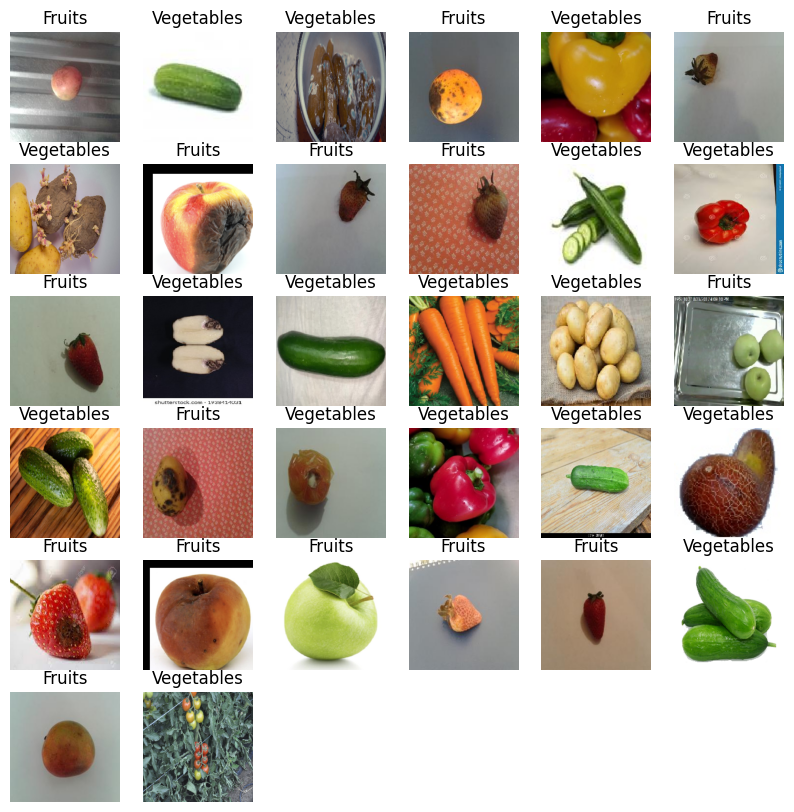

In [ ]:
def display_images_with_labels(dataset, class_names):
    # Get a batch of images and labels from the dataset
    for images, labels in dataset.take(1):  # Take one batch
        images = images.numpy()
        labels = labels.numpy()

        # Calculate the grid size based on the number of images
        num_images = len(images)
        grid_size = int(np.ceil(np.sqrt(num_images)))
        # Calculate grid size for square layout

        # Plot the images
        plt.figure(figsize=(10, 10))
        for i in range(num_images):
            # Use calculated grid size for subplot creation
            ax = plt.subplot(grid_size, grid_size, i + 1)
            plt.imshow(images[i].astype("uint8"))  # Convert float32 to uint8 for display
            plt.title(class_names[labels[i]])  # Use the class name as title
            plt.axis("off")  # Hide axes for better visibility
        plt.show()

# Import numpy for grid size calculation
import numpy as np

# Example usage after dataset is created
display_images_with_labels(dataset, class_names)

In [ ]:
def normalize_image(image, label):
  image= image/255.0
  return image, label


In [ ]:
normalized_dataset = dataset.map(normalize_image)

In [ ]:
# prompt: now split this normalized_dataset into a train_size, val_size and test_size.

train_size = int(len(normalized_dataset) * 0.7)
val_size = int(len(normalized_dataset) * 0.15)
test_size = int(len(normalized_dataset) * 0.15)

train_dataset = normalized_dataset.take(train_size)#training dataset
remaining_dataset = normalized_dataset.skip(train_size)

val_dataset = remaining_dataset.take(val_size)#validation datset
test_dataset = remaining_dataset.skip(val_size)#testing dataset


In [ ]:
train_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
model = Sequential()

In [ ]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
#Train
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=[tensorboard_callback])

Epoch 1/20
262/262 [==============================] - 52s 194ms/step - loss: 0.5123 - accuracy: 0.7514 - val_loss: 0.4001 - val_accuracy: 0.8287
Epoch 2/20
262/262 [==============================] - 46s 174ms/step - loss: 0.3788 - accuracy: 0.8367 - val_loss: 0.2913 - val_accuracy: 0.8739
Epoch 3/20
262/262 [==============================] - 46s 177ms/step - loss: 0.3113 - accuracy: 0.8717 - val_loss: 0.2856 - val_accuracy: 0.8811
Epoch 4/20
262/262 [==============================] - 46s 175ms/step - loss: 0.2559 - accuracy: 0.9006 - val_loss: 0.2093 - val_accuracy: 0.9124
Epoch 5/20
262/262 [==============================] - 46s 175ms/step - loss: 0.2102 - accuracy: 0.9172 - val_loss: 0.1532 - val_accuracy: 0.9431
Epoch 6/20
262/262 [==============================] - 46s 177ms/step - loss: 0.1784 - accuracy: 0.9300 - val_loss: 0.1420 - val_accuracy: 0.9515
Epoch 7/20
262/262 [==============================] - 46s 177ms/step - loss: 0.1227 - accuracy: 0.9536 - val_loss: 0.0828 - val_ac

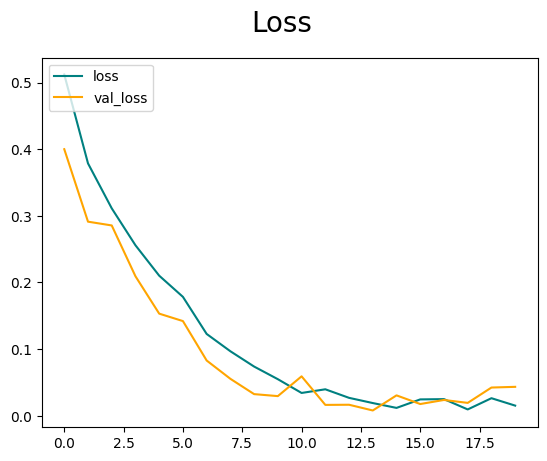

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

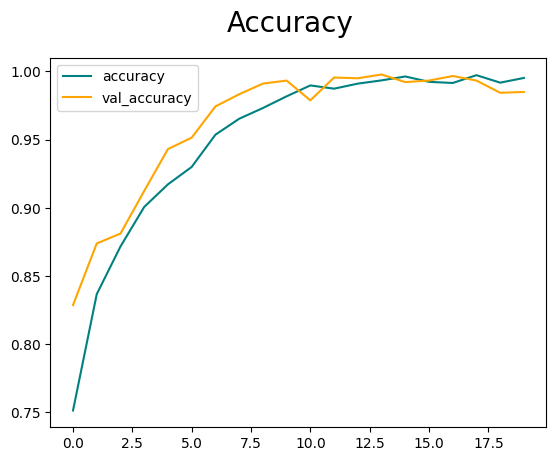

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
# prompt: print an image name from test dataset

for image, label in test_dataset.take(1):
  image_path = image_paths[label.numpy()[0]]
  print(image_path)
  break


/content/Fruits_Vegetables_Dataset(12000)/Fruits/RottenOrange/rottenOrange (551).jpg


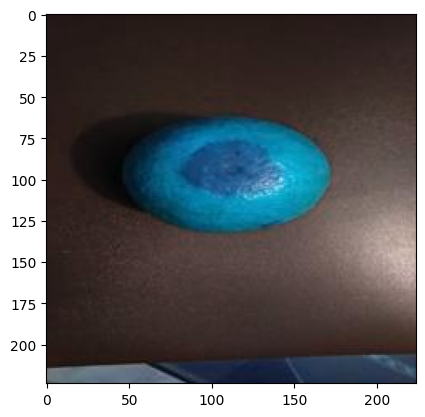

In [ ]:
import cv2
img = cv2.imread('/content/Fruits_Vegetables_Dataset(12000)/Fruits/RottenOrange/rottenOrange (551).jpg')
plt.imshow(img)
plt.show()

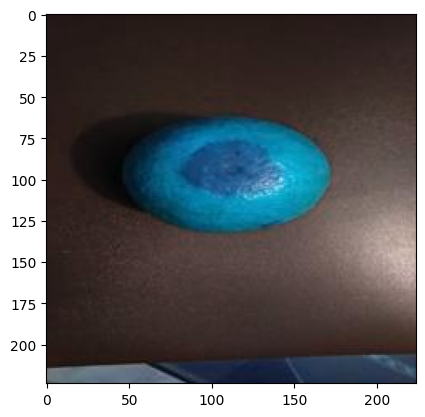

In [ ]:
resize = tf.image.resize(img, (224,224))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))
if yhat > 0.5:
    print(f'Predicted class is Fruit')
else:
    print(f'Predicted class is Vegetable')

1/1 [==============================] - 0s 29ms/step
Predicted class is Fruit


In [ ]:
#save the model
os.makedirs('models', exist_ok=True)
from tensorflow.keras.models import load_model
model.save(os.path.join('models','fruit-vegetableclassifier.keras'))
new_model = load_model(os.path.join('models','fruit-vegetableclassifier.keras'))
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 77ms/step


array([[0.9938908]], dtype=float32)

In [ ]:
import zipfile
import os

def zip_model(model_path, zip_path):
  """Compresses a Keras model into a zip file.

  Args:
    model_path: Path to the Keras model directory.
    zip_path: Path to the output zip file.
  """
  with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(model_path):
      for file in files:
        zipf.write(os.path.join(root, file),
                   os.path.relpath(os.path.join(root, file),
                                   os.path.join(model_path, '..')))

# Call the function to zip the model
# Change 'new_model' to the directory containing your saved model.
zip_path = os.path.join('models','fruit-vegetableclassifier.zip')
# Assuming your saved model is in the 'models' directory.
model_dir = 'models'  # Update if your model is saved elsewhere.
zip_model(model_dir, zip_path)  # Pass the directory path

# Load the zipped model (for verification)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('unzipped_model')
new_model = load_model('unzipped_model/models/fruit-vegetableclassifier.keras')
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 78ms/step


array([[0.9938908]], dtype=float32)